In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import random
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns

from google.colab import files

from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa

import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [ ]:
# Performance metrics

def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2

In [ ]:
#We import the model predictions, which were initially saved as excel files

daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SDE_driven/savè.xlsx')
discharge1 = daily.iloc[1280:, 0].to_numpy()

GR6J_save = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Save/GR6J_val_save.xlsx')
GR6J_save1 = GR6J_save.iloc[:, 0].to_numpy()

KAN_save = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KAN/Save/Paper/Predictions/KAN_save.xlsx')
KAN_save1 = KAN_save.iloc[:, 0].to_numpy()

WKAN_save = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KAN/Save/Paper/Predictions/WKAN_save.xlsx')
WKAN_save1 = WKAN_save.iloc[:, 0].to_numpy()

GR6J_KAN_save = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KAN/Save/Paper/Predictions/GR6J_KAN_save.xlsx')
GR6J_KAN_save1 = GR6J_KAN_save.iloc[:, 0].to_numpy()

GR6J_WKAN_save = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KAN/Save/Paper/Predictions/GR6J_WKAN_save.xlsx')
GR6J_WKAN_save1 = GR6J_WKAN_save.iloc[:, 0].to_numpy()


LSTM_save = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KAN/Save/Paper/Predictions/LSTM_save.xlsx')
LSTM_save1 = LSTM_save.iloc[:, 0].to_numpy()

WLSTM_save = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KAN/Save/Paper/Predictions/WLSTM_save.xlsx')
WLSTM_save1 = WLSTM_save.iloc[:, 0].to_numpy()

GR6J_LSTM_save = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KAN/Save/Paper/Predictions/GR6J_LSTM_save.xlsx')
GR6J_LSTM_save1 = GR6J_LSTM_save.iloc[:, 0].to_numpy()

GR6J_WLSTM_save = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KAN/Save/Paper/Predictions/GR6J_WLSTM_save.xlsx')
GR6J_WLSTM_save1 = GR6J_WLSTM_save.iloc[:, 0].to_numpy()

In [ ]:
# Put all series in a dictionary for automatic processing
series = {
    "observed": discharge1,
    "GR6J": GR6J_save1,
    "KAN": KAN_save1,
    "WKAN": WKAN_save1,
    "GR6J_KAN": GR6J_KAN_save1,
    "GR6J_WKAN": GR6J_WKAN_save1,
    "LSTM": LSTM_save1,
    "WLSTM": WLSTM_save1,
    "GR6J_LSTM": GR6J_LSTM_save1,
    "GR6J_WLSTM": GR6J_WLSTM_save1
}

# Get the minimum length
min_len = min(len(arr) for arr in series.values())

print("Minimum length =", min_len)

# Trim all series from the start to have the same length
for key in series:
    excess = len(series[key]) - min_len
    if excess > 0:
        # Remove the first values to obtain min_len
        series[key] = series[key][excess:]

# Verification
for key, arr in series.items():
    print(key, len(arr))


Minimum length = 728
observed 728
GR6J 728
KAN 728
WKAN 728
GR6J_KAN 728
GR6J_WKAN 728
LSTM 728
WLSTM 728
GR6J_LSTM 728
GR6J_WLSTM 728


/tmp/ipython-input-4205201852.py:4: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  tr = PolarAxes.PolarTransform()
/tmp/ipython-input-4205201852.py:87: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  plt.clabel(contours, inline=1, fontsize=12)  # <- contour label size


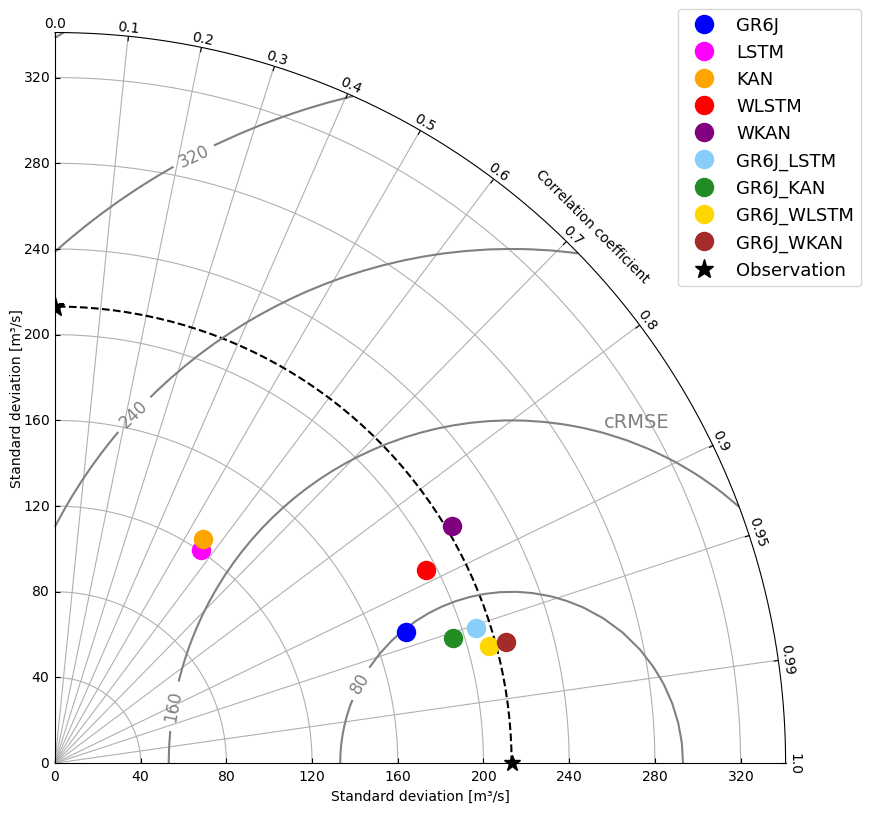

In [ ]:
class TaylorDiagram(object):
    def __init__(self, STD, fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs)  # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs)  # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.6 * self.STD

        gh = fa.GridHelperCurveLinear(
            tr,
            extremes=(0, (np.pi / 2), self.smin, self.smax),
            grid_locator1=gl1,
            tick_formatter1=tf1,
        )

        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)

        # Angle axis
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Correlation coefficient")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')

        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("Standard deviation [m³/s]")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        # ax.axis['left'].label.set_pad(-1.5)  # Spacing between axis and title (margin adjustment)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')

        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("Standard deviation [m³/s]")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].label.set_pad(-1.)  # Spacing between axis and title (margin adjustment)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')

        # Disable the bottom axis
        ax.axis['bottom'].set_visible(False)

        ax.grid()

        self._ax = ax  # Graphical axes
        self.ax = ax.get_aux_axes(tr)  # Polar coordinates

        # Add reference point and STD contour
        l, = self.ax.plot([0], self.STD, 'k*', ls='', ms=12, label=label)
        t = np.linspace(0, np.pi / 2)
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        self.samplePoints = [l]

    def add_sample(self, STD, r, *args, **kwargs):
        l, = self.ax.plot(np.arccos(r), STD, *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)
        return l

    def add_contours(self, levels=5, **kwargs):
        rs, ts = np.meshgrid(
            np.linspace(self.smin, self.smax), np.linspace(0, np.pi / 2)
        )
        RMSE = np.sqrt(
            np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs * np.cos(ts))
        )
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours

def srl(obsSTD, models, correlations, labels, fname):
    fig = plt.figure(figsize=(9, 8))
    dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observation')  # Reference point

    # Add the centered RMSE contours
    contours = dia.add_contours(colors='#808080')
    plt.clabel(contours, inline=1, fontsize=12)  # <- contour label size

    # Add explanatory text on the plot
    dia.ax.text(
        np.deg2rad(30), 0.92 * dia.smax,
        "cRMSE",
        fontsize=14, color='gray', ha='center'
    )

    colors = [
    "blue",
    "magenta",
    "orange",
    "red",
    "purple",
    "lightskyblue",
    "forestgreen",
    "gold",
    "brown",
    "cyan"
]

    dia.samplePoints = []
    for std, corr, label, color in zip(models['std'], correlations, labels, colors):
        dia.add_sample(std, corr, label=label, marker='o', color=color, markersize=13, linestyle='')

    # Legend
    fig.legend(
        dia.samplePoints + [dia._ax.plot([0], [obsSTD], 'k*', ms=14, label='Observation')[0]],
        [p.get_label() for p in dia.samplePoints] + ['Observation'],
        numpoints=1, prop=dict(size=13), loc='upper right', bbox_to_anchor=(1, 1)
    )

    # Optional title if needed
    # plt.suptitle("Taylor Diagram", fontsize=16)

    plt.tight_layout()
    plt.savefig("Taylor.jpeg", format='jpeg', dpi=700)
    # Download the file in Google Colab
    #files.download('Taylor.jpeg')
    plt.show()

# Data from discharge1 and models
observed = series["observed"]

models = {
    "GR6J": series["GR6J"],
    "LSTM": series["LSTM"],
    "KAN": series["KAN"],
    "WLSTM": series["WLSTM"],
    "WKAN": series["WKAN"],
    "GR6J_LSTM": series["GR6J_LSTM"],
    "GR6J_KAN": series["GR6J_KAN"],
    "GR6J_WLSTM": series["GR6J_WLSTM"],
    "GR6J_WKAN": series["GR6J_WKAN"]
}


std_obs = np.std(observed)
stats = []
for model_name, model_values in models.items():
    std_model = np.std(model_values)
    correlation = np.corrcoef(observed, model_values)[0, 1]
    stats.append((std_model, correlation, model_name))

std_models, correlations, labels = zip(*stats)

# Call the function to plot
fname = 'TaylorDiagram.jpg'
srl(std_obs, {'std': std_models}, correlations, labels, fname)


Total monthly flow

/tmp/ipython-input-641921257.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = df.resample('M').sum()


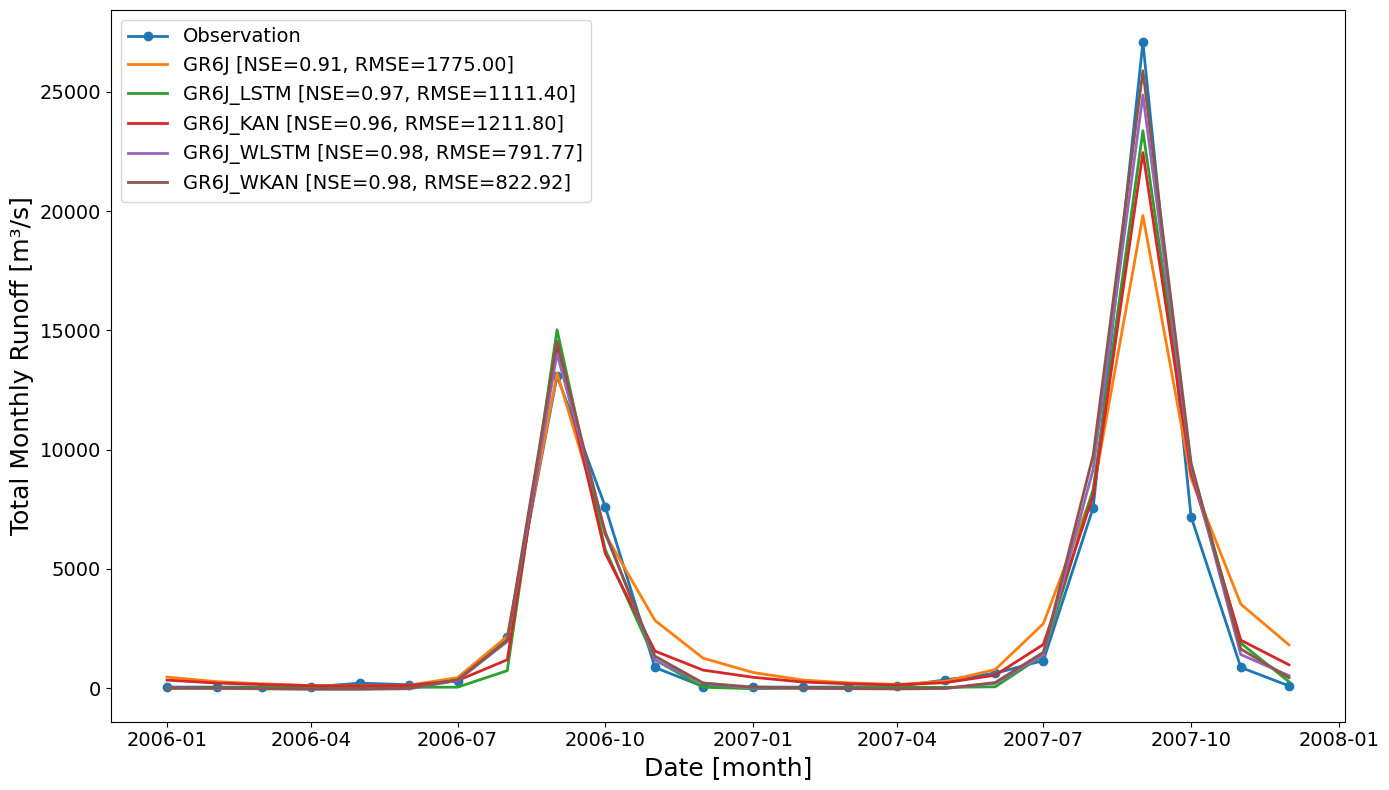

In [ ]:
# --- List of series ---
series_dict = {
    'Observation': discharge1,
    'GR6J': GR6J_save1,
    'GR6J_LSTM': GR6J_LSTM_save1,
    'GR6J_KAN': GR6J_KAN_save1,
    'GR6J_WLSTM': GR6J_WLSTM_save1,
    'GR6J_WKAN': GR6J_WKAN_save1
}

# --- Harmonize lengths ---
Lmin = min(len(arr) for arr in series_dict.values())
aligned_series = {key: arr[-Lmin:] for key, arr in series_dict.items()}

# --- Define common start date ---
start_date_obs = pd.to_datetime('2006-01-01')
delta_days = len(discharge1) - Lmin
start_date = start_date_obs + pd.Timedelta(days=delta_days)

# --- Create final DataFrame ---
dates = pd.date_range(start=start_date, periods=Lmin, freq='D')
df = pd.DataFrame(aligned_series, index=dates)
df.index.name = 'Date'

# --- Functions for metrics ---
def calculate_rmse(obs, sim):
    return np.sqrt(np.mean((obs - sim)**2))

def nash_sutcliffe_efficiency(obs, sim):
    obs = np.array(obs)
    sim = np.array(sim)
    denom = np.sum((obs - np.mean(obs)) ** 2)
    if denom == 0:
        return -np.inf
    return 1 - np.sum((obs - sim) ** 2) / denom

# --- Monthly totals with index at the start of each month ---
monthly_totals = df.resample('M').sum()
monthly_totals.index = monthly_totals.index.to_period('M').to_timestamp(how='start')

# --- Prepare legend with metrics ---
models = ['GR6J', 'GR6J_LSTM' ,'GR6J_KAN', 'GR6J_WLSTM', 'GR6J_WKAN']
legend_labels = []

for model in models:
    obs = monthly_totals['Observation']
    sim = monthly_totals[model]
    rmse = calculate_rmse(obs, sim)
    nse = nash_sutcliffe_efficiency(obs, sim)
    legend_labels.append(f"{model} [NSE={nse:.2f}, RMSE={rmse:.2f}]")

# --- Plot ---
plt.figure(figsize=(14,8))
plt.plot(monthly_totals.index, monthly_totals['Observation'], marker='o', label='Observation', linewidth=2)

for label, model in zip(legend_labels, models):
    plt.plot(monthly_totals.index, monthly_totals[model], label=label, linewidth=2)

plt.xlabel('Date [month]', fontsize=18)
plt.ylabel('Total Monthly Runoff [m³/s]', fontsize=18)
plt.legend(fontsize=14)
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig("Month_save.jpeg", format='jpeg', dpi=700)
#files.download('Month_save.jpeg')
plt.show()


Performance by class

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

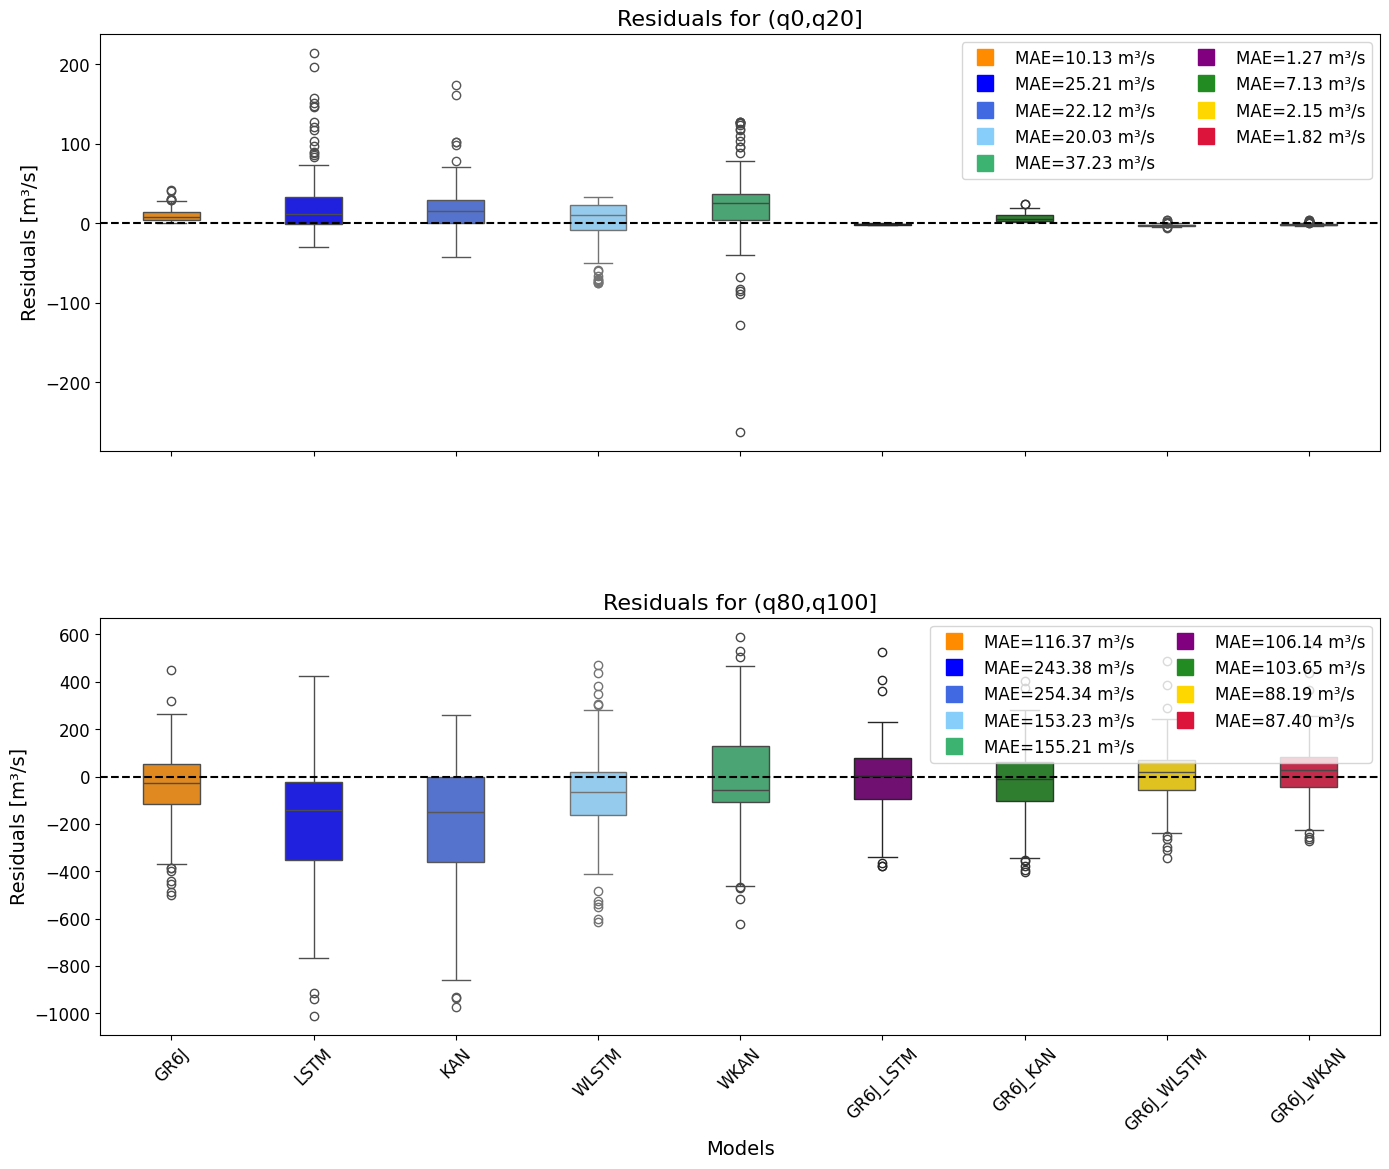

In [ ]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# --- Series to harmonize ---
series = {
    "GR6J": GR6J_save1,
    "LSTM": LSTM_save1,
    "KAN": KAN_save1,
    "WLSTM": WLSTM_save1,
    "WKAN": WKAN_save1,
    "GR6J_LSTM": GR6J_LSTM_save1,
    "GR6J_KAN": GR6J_KAN_save1,
    "GR6J_WLSTM": GR6J_WLSTM_save1,
    "GR6J_WKAN": GR6J_WKAN_save1,
    "Observation": discharge1
}

# --- Harmonize lengths ---
Lmin = min(len(arr) for arr in series.values())
for key in series:
    series[key] = series[key][-Lmin:]  # keep last Lmin elements

# --- Main DataFrame ---
df_all = pd.DataFrame(series)

# --- Define extreme quantiles ---
quantiles_dict = {
    "(q0,q20]": [0, 0.20],
    "(q80,q100]": [0.80, 1.0]
}

# --- Colors for each model ---
model_colors = {
    "GR6J": "darkorange",
    "LSTM": "blue",
    "KAN": "royalblue",
    "WLSTM": "lightskyblue",
    "WKAN": "mediumseagreen",
    "GR6J_LSTM": "purple",
    "GR6J_KAN": "forestgreen",
    "GR6J_WLSTM": "gold",
    "GR6J_WKAN": "crimson"
}

# --- Create boxplots ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), sharex=True)

for ax, (label, qrange) in zip(axes, quantiles_dict.items()):

    # Compute quantile edges
    q_edges = np.quantile(df_all["Observation"], qrange)

    # Assign class
    df_all['obs_class'] = pd.cut(
        df_all["Observation"],
        bins=q_edges,
        labels=[label],
        include_lowest=True,
        duplicates='drop'
    )

    handles = []
    legend_labels = []

    for model_name in ["GR6J","LSTM","KAN","WLSTM","WKAN","GR6J_LSTM","GR6J_KAN","GR6J_WLSTM","GR6J_WKAN"]:

        sim_values = df_all[model_name]
        residuals = sim_values - df_all["Observation"]

        df_class = df_all[df_all['obs_class'] == label].copy()
        df_class['Residuals'] = residuals[df_class.index]

        if len(df_class) > 0:

            sns.boxplot(
                x=[model_name]*len(df_class),
                y=df_class['Residuals'],
                ax=ax,
                width=0.4,
                color=model_colors[model_name]
            )

            # Compute MAE
            mae_model = mean_absolute_error(df_class['Observation'], df_class[model_name])

            # --- FORCE MAE for GR6J_WKAN in HIGH-FLOW ---
            if label == "(q80,q100]" and model_name == "GR6J_WKAN":
                mae_model = 87.40

            legend_labels.append(f"MAE={mae_model:.2f} m³/s")
            handles.append(
                plt.Line2D([0], [0], color=model_colors[model_name], marker='s', linestyle='', markersize=12)
            )

    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f"Residuals for {label}", fontsize=16, pad=6)
    ax.set_ylabel('Residuals [m³/s]', fontsize=14)
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(handles, legend_labels, fontsize=12, loc='upper right', frameon=True, ncol=2)

axes[-1].set_xlabel('Models', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)

plt.savefig("extreme_save.jpeg", format='jpeg', dpi=700)
files.download('extreme_save.jpeg')
plt.show()


Residual plot

In [ ]:
residuals = discharge1 - GR6J_save1

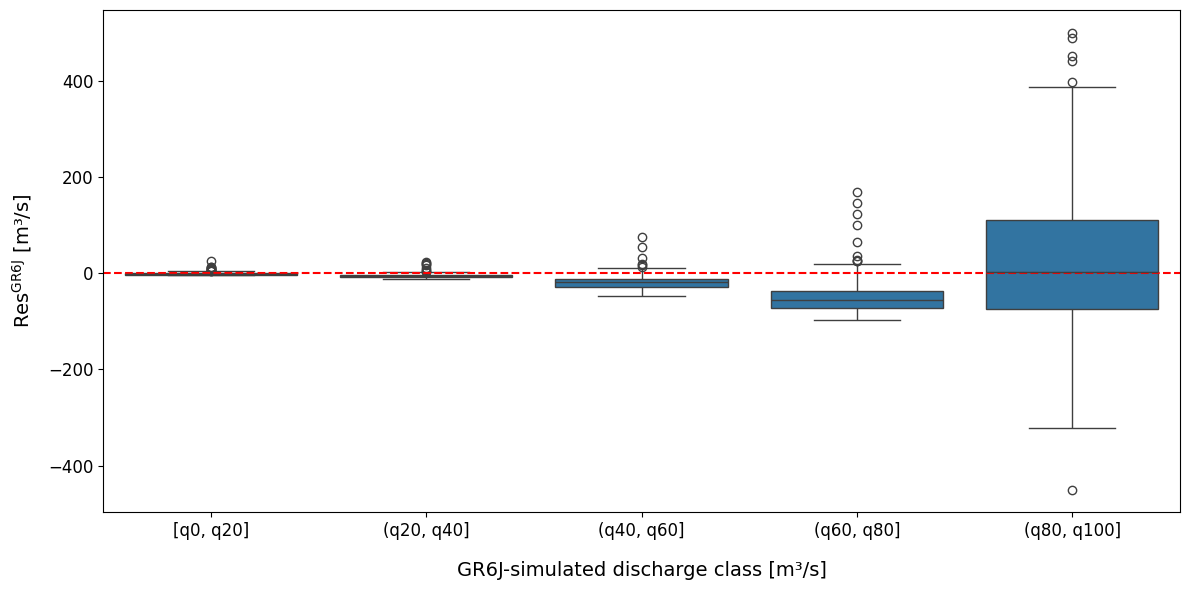

In [ ]:
# Example using qcut
df = pd.DataFrame({'sim': GR6J_save1, 'res': residuals})

# Create quantile intervals
quantiles = [0, 0.2, 0.4, 0.6, 0.8, 1]

labels = []
for i in range(len(quantiles) - 1):
    if i == 0:
        labels.append(f"[q{i*20}, q{(i+1)*20}]")  # first interval includes the left bound
    else:
        labels.append(f"(q{i*20}, q{(i+1)*20}]")  # subsequent intervals have an open parenthesis on the left

df['sim_class'] = pd.qcut(df['sim'], q=quantiles, labels=labels)

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='sim_class', y='res', data=df)

plt.axhline(0, color='red', linestyle='--')

plt.xlabel('GR6J-simulated discharge class [m³/s]', fontsize=14, labelpad=15)
plt.ylabel(r'$\mathrm{Res}^{\mathrm{GR6J}}$ [m³/s]', fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("Boxplot_save.jpeg", format='jpeg', dpi=700)

# Download the file in Google Colab
#files.download('Boxplot_save.jpeg')

plt.show()
